In [ ]:
import sys
import os
import numpy as np 
import matplotlib as mpl 
from config.plot_config_2 import *
from skimage.filters import threshold_otsu

sys.path.append(os.path.abspath('packages'))
from utilities import *

os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/texlive/2023/bin/x86_64-linux' + ':/usr/bin/pdflatex'


plt.rc('text', usetex=False)
plt.rc('font', family='serif')


### Load data for Histogram plots 

In [4]:
t1_data = np.load('data/10_EGFR_MM_hist.npy', allow_pickle=True)
t1_data = t1_data.item()

In [5]:
alpha_list = t1_data['alpha_list']
beta_list = t1_data['beta_list']
weights_list = t1_data['weights_list']
beta_err_list = t1_data['beta_error_list']
emp_var_list = t1_data['emp_var_list']
epsilon_list = t1_data['epsilon_list']
dt_list = t1_data['dt_list']
S_list = t1_data['S_list']

### Loading chemical network parameters

In [11]:
netw = make_par('egfr')
dynamics, S, f = get_dynamics()
netw['dynamics'] = dynamics
netw = refresh_netw_par(netw)

#### Calculate $\beta_\epsilon$

In [ ]:
beta_dev = np.abs(emp_var_list/(1/beta_list - emp_var_list))

In [14]:
def threshold_otsu_list_rep(lst, netw): 
    '''
    Inputs: 
        - lst: (Nrep, num_subnw) list of (beta) values
        - names: (num_subnw) names of correspoding units
    '''

    # lst = np.log10(lst.copy())
    
    thresh = 10**threshold_otsu(np.log10(np.array(lst).flatten()))

    idx_inner_rel = netw['idx_inner_rel'] 
    idx_boundary_rel = netw['idx_boundary_rel']

    TN = np.sum(lst[:, idx_inner_rel] > thresh)
    FP = np.sum(lst[:, idx_inner_rel] < thresh)

    TP = np.sum(lst[:, idx_boundary_rel] < thresh)
    FN = np.sum(lst[:, idx_boundary_rel] > thresh)

    return {'TP':TP, 'FP':FP, 'TN': TN, 'FN':FN, 'thresh': thresh}

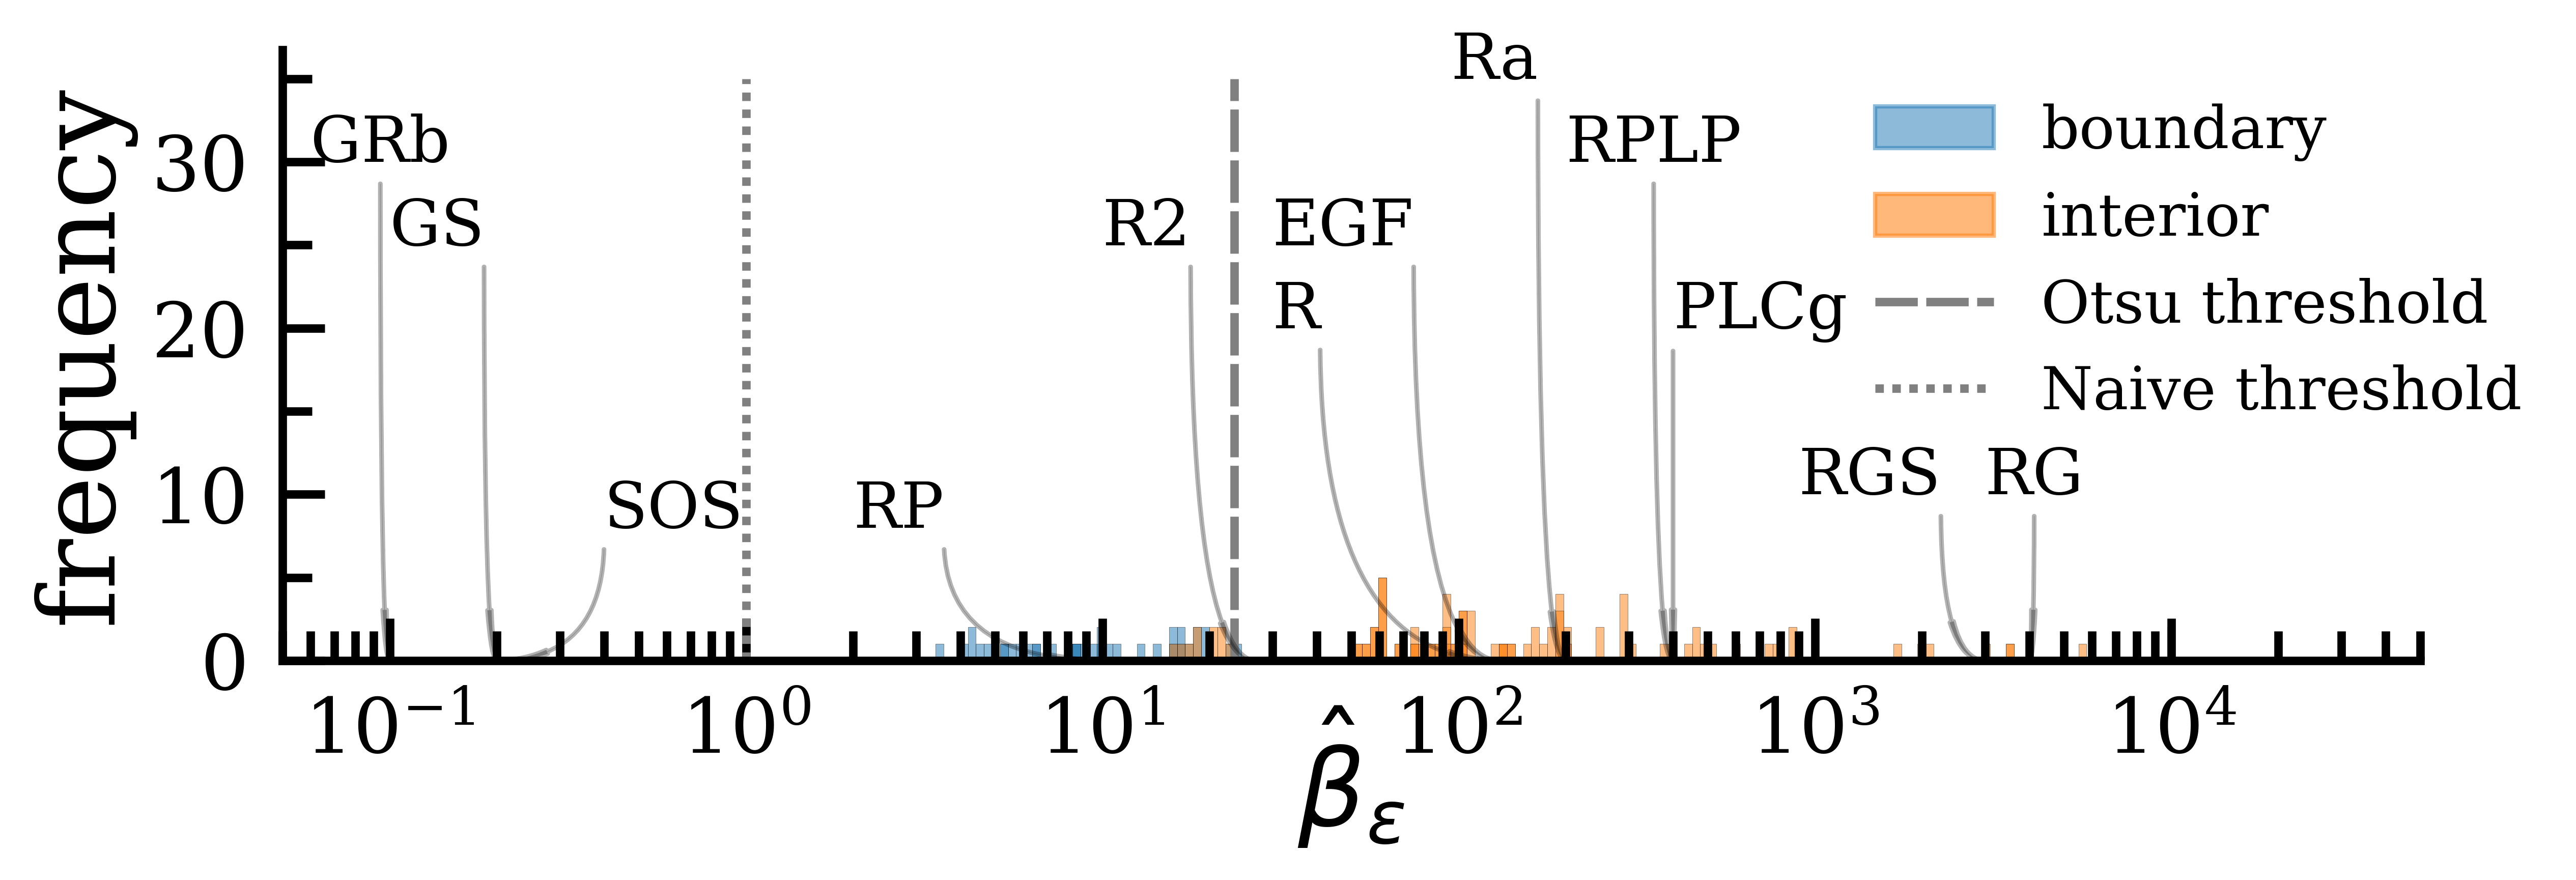

In [16]:
import matplotlib.patches as mpatches


idx_dt = 0 
idx_eps = 0

vec = beta_dev[ idx_eps, idx_dt]
threshold = threshold_otsu_list_rep(vec, netw)['thresh']


boundary = netw['units_boundary']
subnw = netw['units_subnw']


x = np.array(vec)
n_boundary = len(vec)


# precomputation
n_bins = 200
hist, bins, _ = plt.hist(x.flatten(), bins=n_bins)
plt.close()


fig = plt.figure(figsize=(7, 2), dpi=600)
ax = fig.add_axes([0, 0, 1, 1])



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Edit the major and minor ticks of the x and y 
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top=False, pad=8)
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in' , top=False, pad=3)
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right=False)
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in' , right=False, pad=3)



logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

for idx_u, unit in enumerate(subnw): 
    color = 'b' if unit not in boundary else 'r' 

x_inner = x[:, netw['idx_inner_rel']].flatten()
x_boundary = x[:, netw['idx_boundary_rel']].flatten()


num_subnw = len(netw['units_subnw'])
index_sorted = np.array(list(sorted(zip([np.mean(x[:, idx]) for idx in range(num_subnw)], np.arange(num_subnw)),  \
    key=lambda k: k[0])))[:, 1].astype(int)

last_mean = 1
height_text = -20
for idx_count, idx_u in enumerate(index_sorted): 
    unit = netw['units_subnw'][idx_u]

    mean = np.mean(x[:, idx_u])
    color = COLORS(0) if unit in netw['units_boundary'] else COLORS(1)
    _, bins, patches = ax.hist(x[:, idx_u], color=color, bins=logbins, alpha=.5, edgecolor='k', lw=.1)
    idx_mean = np.argmin(np.abs(mean - bins))

    x_bin_mean = bins[idx_mean]
    diff = np.log10(x_bin_mean) - np.log10(last_mean) 
    last_mean = x_bin_mean


for label, xy, xytext in [['GRb', (1e-1, 0), (.6e-1, 30)], ['GS',(2e-1, 0), (1e-1, 25) ], ['SOS', (2e-1, 0), (4e-1, 8)], ['RP', (1e1, 0), (2e0, 8)], ['R2', (2.7e1, 0), (1e1, 25)], ['R', (1.3e2, 0), (3e1, 20)], ['EGF', (1.3e2, 0), (3e1, 25)], ['Ra', (2e2, 0), (9.5e1, 35)], ['RPLP', (4e2, 0), (2e2, 30)], ['PLCg', (4e2, 0), (4e2, 20)], ['RGS', (3e3,0), (9e2, 10) ], ['RG', (4e3, 0), (3e3, 10)]]: #, 'GS', 'SOS', 'RP', 'R2', 'EGF', 'Ra', 'GS', 'RG'], )

    connectionstyle = mpl.patches.ConnectionStyle.Angle(angleA=-90, angleB=180, rad=5) #xycoords='figure fraction',
    ax.annotate(f'{label}', xy=xy, xytext=xytext,  fontsize=15, \
        arrowprops={'width':0.1, 'headwidth':1, 'color':'k', 'alpha':.3, 'connectionstyle':'angle3'} )
    


t1_patch = ax.vlines(threshold, 0, 35, ls=(0,(5, 1)), color='grey', label='Otsu threshold', lw=2)
t2_patch = ax.vlines(1, 0, 35, ls=(0,(1,1)), color='grey', label='Naive threshold', lw=2)

ax.set_xscale('log')
ax.set_xlabel(s_beta_red_hat, labelpad=-15)
ax.set_ylabel('frequency')



ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.set_xlim([0.05, 5e4])

boundary_patch = mpl.patches.Patch(color=COLORS(0), label='boundary', alpha=.5)
inner_patch = mpl.patches.Patch(color=COLORS(1), label='interior', alpha = .55)
ax.legend(handles=[boundary_patch, inner_patch, t1_patch, t2_patch], bbox_to_anchor=(.72, 1),loc=2, frameon=False, bbox_transform=ax.transAxes, fontsize=14)


ax.patch.set_alpha(0)
#plt.savefig('../pic_paper/otsu_threshold_noisy_50rep.png', bbox_inches='tight')